# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [1]:
# TODO: Make all necessary imports.
import warnings
warnings.filterwarnings('ignore')

In [31]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar() #to remove clutter on the screen

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR) #prevent too many warning messages printed out

In [4]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.0.0
	• tf.keras version: 2.2.4-tf
	• GPU device not found. Running on CPU


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [5]:
# TODO: Load the dataset with TensorFlow Datasets.
dataset, dataset_info = tfds.load('oxford_flowers102', shuffle_files=True, as_supervised = True, with_info = True)
#as_supervised =True tells tensorflow dataset to also return the corresponding labels of the images in our training set
#this will be used when we train our neural network

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/0.0.1. Subsequent calls will reuse this data.


In [6]:
#check dataset datatype so that we know how to behave
type(dataset), type(dataset_info)

(dict, tensorflow_datasets.core.dataset_info.DatasetInfo)

In [7]:
print('Dataset has type:', type(dataset))
print('In the keys of the dataset are:', list(dataset.keys()))

Dataset has type: <class 'dict'>
In the keys of the dataset are: ['test', 'train', 'validation']


In [8]:
#Visualise dataset_info
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=0.0.1,
    description='
The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1030 images each).
The test set consist of the remaining 6129 images (minimum 20 per class).
',
    urls=['https://www.robots.ox.ac.uk/~vgg/data/flowers/102/'],
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
    }),
    total_num_examples=81

In [9]:
print('Total number of images in the dataset: {}'.format(dataset_info.splits.total_num_examples))
print('Our dataset is divided as follows:\n {}'.format(dataset_info.splits))
#supervised_keys Specifies the input feature and the label for supervised learning, if applicable for the dataset. 
#The keys correspond to the feature names to select in info.features
print('Input feature and the label for supervised learning are: {}'.format(dataset_info.supervised_keys))

Total number of images in the dataset: 8189
Our dataset is divided as follows:
 {'test': <tfds.core.SplitInfo num_examples=6149>, 'train': <tfds.core.SplitInfo num_examples=1020>, 'validation': <tfds.core.SplitInfo num_examples=1020>}
Input feature and the label for supervised learning are: ('image', 'label')


In [10]:
# TODO: Create a training set, a validation set and a test set.
training_set, test_set, valid_set = dataset['test'], dataset['train'], dataset['validation']
#get the datatypes for training_set 
type(training_set)

tensorflow.python.data.ops.dataset_ops._OptionsDataset

## Explore the Dataset

We use dot notation to access information we want as shown in https://youtu.be/gx9rZl-LHl8 (sec 4.28) Lesson 4 Deep Learning with Tensor Flow

In [11]:
# TODO: Get the number of examples in each set from the dataset info.
#https://github.com/tensorflow/datasets/issues/1656
num_total_examples = dataset_info.splits.total_num_examples
dataset_info.splits['train'].num_examples + dataset_info.splits['test'].num_examples + dataset_info.splits['validation'].num_examples
print('There are {:,} total images in the dataset'.format(num_total_examples))
num_training_examples = dataset_info.splits['train'].num_examples
print('\nThere are {:,} images in the training set'.format(num_training_examples))
num_test_examples = dataset_info.splits['test'].num_examples
print('\nThere are {:,} images in the test set'.format(num_test_examples))
num_valid_examples = dataset_info.splits['validation'].num_examples
print('\nThere are {:,} images in the validation set'.format(num_valid_examples))

# TODO: Get the number of classes in the dataset from the dataset info.
num_classes = dataset_info.features['label'].num_classes
print('\nThere are {:,} classes in our dataset'.format(num_classes))

There are 8,189 total images in the dataset

There are 1,020 images in the training set

There are 6,149 images in the test set

There are 1,020 images in the validation set

There are 102 classes in our dataset


In [12]:
dataset_info.features

FeaturesDict({
    'file_name': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
})

In [13]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for image, label in training_set.take(3):
    print(dataset_info.features['image'].shape)
    
#It looks like different images have different sizes

(None, None, 3)
(None, None, 3)
(None, None, 3)


In [14]:
counter = 1
for image, label in training_set.take(3):
    print('\nThe {} image in the training set has:'.format(str(counter) + 'st' if counter == 1 else str(counter) + 'nd'))
    print('\u2022 dtype:', image.dtype) 
    print('\u2022 shape:', image.shape)
  
    print('\nThe {} images label have:'.format(str(counter) + 'st' if counter == 1 else str(counter) + 'nd'))
    print('\u2022 dtype:', label.dtype)
    print('\u2022 shape:', label.shape)
    print('\u2022 value:', label)
    counter = int(counter) + 1  


The 1st image in the training set has:
• dtype: <dtype: 'uint8'>
• shape: (500, 752, 3)

The 1st images label have:
• dtype: <dtype: 'int64'>
• shape: ()
• value: tf.Tensor(56, shape=(), dtype=int64)

The 2nd image in the training set has:
• dtype: <dtype: 'uint8'>
• shape: (500, 525, 3)

The 2nd images label have:
• dtype: <dtype: 'int64'>
• shape: ()
• value: tf.Tensor(101, shape=(), dtype=int64)

The 3nd image in the training set has:
• dtype: <dtype: 'uint8'>
• shape: (500, 519, 3)

The 3nd images label have:
• dtype: <dtype: 'int64'>
• shape: ()
• value: tf.Tensor(88, shape=(), dtype=int64)


It looks like images are of `unit8` **Data Type**, that is Unsigned integer (0 to 255) and labels are of `int32` that is Integer (-2147483648 to 2147483647). We use NumPy here because NumPy supports a much greater variety of numerical types than Python does. [Here](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.types.html) a link for Array types and conversions between types

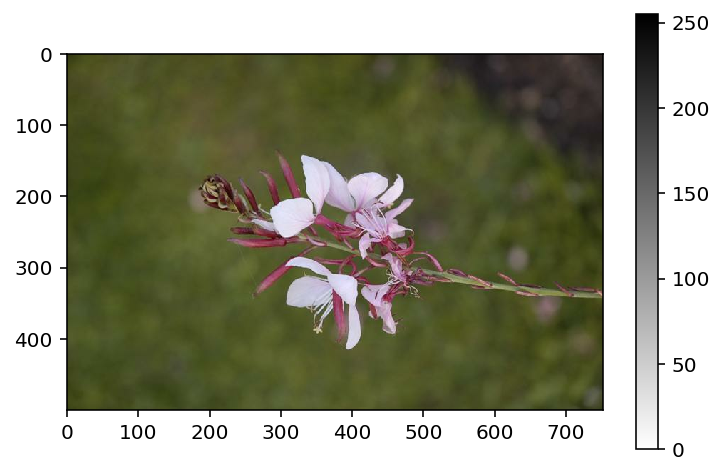

The label of this image is: 56


In [15]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding image label. 
for image, label in training_set.take(1):
    image = image.numpy().squeeze() #remove single-dimensional entries from the shape of an array
    label = label.numpy()
    
# Plot the image
plt.imshow(image, cmap = plt.cm.binary)
plt.colorbar()
plt.show()

print('The label of this image is:', label)

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [16]:
import json
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

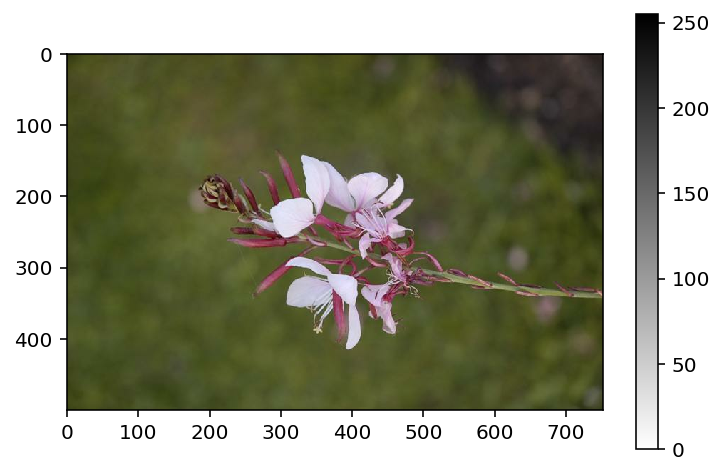

The label of this image is: Bishop of llandaff


In [18]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()
    
# Plot the image
plt.imshow(image, cmap = plt.cm.binary)
plt.colorbar()
plt.show()

print('The label of this image is:', class_names.get(str(label)).capitalize())

## Create Pipeline

A pipeline is a set of transformations that we apply to our data so that it can be fed efficiently to ur neural network. As we can see, the pixel values of our images are in the range [0, 255]. First thing first we normalize the images and create a pipeline with each set so that it can be fed into our neural network. In order to normalize the images we are have to divide the pixel values by 255. We will therefore, first change the dtype of our image from uint8 to float32 (32-bit single-precision floating-point numbers) using the tf.cast function. Our images have to be rescaled between 0 and 1.

Once we have dealt with image datatype, we use `.cache()`, a method that moves our data into memory for quick access. We should only use `.cache()` if we have enough memory to fit our dataset. Secondly, we use `.shuffle()` a method that randomly shuffles our images in our dataset (which we could also use when we load the dataset from tfds) and takes one argument (the number of the images in the training set for instance) that represents the number of images we want to shuffle. We then use `.map()` , then `batch()` with the desired batch_size. The order at which we use the functions is very important. We should use map(normalize) before the batch(batch_size). Otherwise our images will not have the same shape because batches are created before that if we were to anticipate batch() to map(). 

Data is normalized and resized to 224x224 pixels as required by the pre-trained networks. We will be usinng convolutional neural network that takes an input of 224x224 pixels.

We may want to use .prefetch(1) if we wanted to use the first of these batches.

In [51]:
# TODO: Create a pipeline for each set.
#Data Augmentation - Generally we only do this with the training set 
train_data_generator = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')


batch_size = 32 #I choose a smaller batch so that it can comfortably fit in my computer's memory
image_size = 224 #Data is normalized and resized to 224x224 pixels as required by the pre-trained networks


def normalize(image, label):
    '''
    Gets an array of images and 
    returns an array of floats 
    normalized and resized to 224x224
    pixels as required by the pre-trained networks
    '''
    image = tf.cast(image, tf.float32) #from  unit8 to float32
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255 #rescaling images to be between 0 and 1
    return image, label



training_batches = training_set.cache().shuffle(num_training_examples//4).map(normalize).batch(batch_size)
test_batches = test_set.cache().shuffle(num_test_examples//4).map(normalize).batch(batch_size)
valid_batches = valid_set.cache().shuffle(num_valid_examples//4).map(normalize).batch(batch_size)

We notice we created the pipeline with a batch size of 32, and that we are shuffling our dataset. The batch size is the number of images we get in one iteration and are passed through our network, often called a batch. The shuffle transformation randomly shuffles the elements of our dataset before being fed to our network.

Although many of these transformations are commutative, the ordering of certain transformations has performance implications. For more information on these transformations and their impact on performance make sure to check the following links:
* [Pipeline performance](https://www.tensorflow.org/guide/data_performance)
* [Transformations](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

Now, let's see how we can grab a single image from our one of our batches.

In [28]:
for image_batch, label_batch in training_batches.take(1):
    print('The images in each batch have:')
    print('\u2022 dtype:', image_batch.dtype) 
    print('\u2022 shape:', image_batch.shape)
  
    print('\nThere are a total of {} image labels in this batch:'.format(label_batch.numpy().size))
    print(label_batch.numpy())

The images in each batch have:
• dtype: <dtype: 'float32'>
• shape: (32, 224, 224, 3)

There are a total of 32 image labels in this batch:
[101  31  91  57  72  58  59  76  82  41  92  57   7  36  45  58  27  57
   5   1  81  93  56  84  55  62  67  98   3  83  11  28]


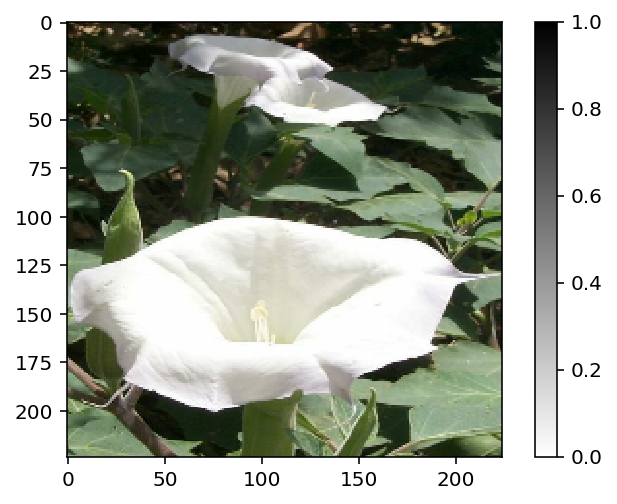

The label of this image is: 74


In [44]:
# Take a single batch of images, and remove the color dimension by squeezing it
for image_batch, label_batch in training_batches.take(1):
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()

# Plot the image
plt.imshow(images[0], cmap = plt.cm.binary)
plt.colorbar()
plt.show()

print('The label of this image is:', labels[0])

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [47]:
# TODO: Build and train your network.



<tf.Tensor: id=1233, shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[9.34288576e-02, 7.43520111e-02, 7.96490349e-04],
         [2.75647223e-01, 2.46743232e-01, 1.57938898e-01],
         [4.39622939e-01, 3.91618729e-01, 2.97816187e-01],
         ...,
         [5.06039746e-02, 8.01295340e-02, 4.80654575e-02],
         [2.68644243e-02, 7.39232451e-02, 2.68644243e-02],
         [2.86911279e-02, 7.57499561e-02, 2.86911279e-02]],

        [[6.17737696e-02, 6.77699223e-02, 9.17398091e-03],
         [9.94480625e-02, 9.30229947e-02, 2.14978959e-02],
         [1.42488733e-01, 1.19791672e-01, 3.74996141e-02],
         ...,
         [4.57811579e-02, 8.49968493e-02, 4.97027263e-02],
         [1.92929339e-02, 6.63517565e-02, 1.92929339e-02],
         [1.75332632e-02, 6.45920858e-02, 1.75332632e-02]],

        [[7.15397000e-02, 8.72259811e-02, 3.23240235e-02],
         [7.31784925e-02, 8.06281120e-02, 2.62509696e-02],
         [9.43867490e-02, 8.83513615e-02, 1.78746544e-02],
         ...,
 

In [20]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.



## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [21]:
# TODO: Print the loss and accuracy values achieved on the entire test set.



## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [22]:
# TODO: Save your trained model as a Keras model.



## Load the Keras Model

Load the Keras model you saved above.

In [23]:
# TODO: Load the Keras model



# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [24]:
# TODO: Create the process_image function



To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

In [25]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

NameError: name 'process_image' is not defined

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [ ]:
# TODO: Create the predict function



# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

In [ ]:
# TODO: Plot the input image along with the top 5 classes
